# Import Agribalyse and link to ecoinvent 2.2

[Agribalyse](http://www.ademe.fr/en/expertise/alternative-approaches-to-production/agribalyse-program) is a French LCI database of agricultural products. It builds on top of ecoinvent 2.2. It was exported from SimaPro, so the names of ecoinvent processes are mangled, and need to be fixed back to standard ecoinvent.

This notebook uses Agribalyse 1.2, released in March 2015.

In [1]:
from brightway2 import *

Create a new project for this notebook

In [2]:
projects.set_current("Agribalyse")

## Add biosphere flows

Biosphere flow names follow the standard in ecoinvent 3.3. We will need to match these names to those in Agribalyse.

In [3]:
bw2setup()

Creating default biosphere



Writing activities to SQLite3 database:
0%                          100%
[######                        ] | ETA: 00:00:00

Applying strategy: normalize_units
Applying strategy: drop_unspecified_subcategories
Applied 2 strategies in 0.01 seconds


[##############################] | ETA: 00:00:00
Total time elapsed: 00:00:00


Title: Writing activities to SQLite3 database:
  Started: 11/30/2016 14:34:27
  Finished: 11/30/2016 14:34:27
  Total time elapsed: 00:00:00
  CPU %: 100.10
  Memory %: 0.93
Created database: biosphere3
Creating default LCIA methods

Applying strategy: normalize_units
Applying strategy: set_biosphere_type
Applying strategy: drop_unspecified_subcategories
Applying strategy: link_iterable_by_fields
Applied 4 strategies in 2.16 seconds
Wrote 718 LCIA methods with 178008 characterization factors
Creating core data migrations



## Import ecoinvent 2.2 as background database

In [4]:
path = "/Users/cmutel/Documents/LCA Documents/Ecoinvent/2.2/processes"
importer = SingleOutputEcospold1Importer(path, "ecoinvent 2.2")
importer.apply_strategies()
importer.statistics()

Extracting XML data from 4087 datasets
Extracted 4087 datasets in 3.68 seconds
Applying strategy: normalize_units
Applying strategy: assign_only_product_as_production
Applying strategy: clean_integer_codes
Applying strategy: drop_unspecified_subcategories
Applying strategy: normalize_biosphere_categories
Applying strategy: normalize_biosphere_names
Applying strategy: strip_biosphere_exc_locations
Applying strategy: set_code_by_activity_hash
Applying strategy: link_iterable_by_fields
Applying strategy: link_technosphere_by_activity_hash
Applied 10 strategies in 4.95 seconds
4087 datasets
135892 exchanges
0 unlinked exchanges
  


(4087, 135892, 0)

In [5]:
importer.write_database()

Writing activities to SQLite3 database:
0%                          100%
[##############################] | ETA: 00:00:00
Total time elapsed: 00:00:19


Title: Writing activities to SQLite3 database:
  Started: 11/30/2016 14:36:13
  Finished: 11/30/2016 14:36:33
  Total time elapsed: 00:00:19
  CPU %: 97.10
  Memory %: 1.91
Created database: ecoinvent 2.2


Brightway2 SQLiteBackend: ecoinvent 2.2

## Load Agribalyse data

This notebook uses the ecospold 1 version of Agribalyse, but the SimaPro CSV version should be quite similar, it would just use a different `Importer` class.

We only need to give the directory, the `Importer` will find the XML file.

In [3]:
path = "/Users/cmutel/Documents/LCA Documents/Agribalyse"
ag = SingleOutputEcospold1Importer(path, "Agribalyse 1.2")
ag.apply_strategies()
ag.statistics()

Extracting XML data from 1 datasets


Extracted 822 datasets in 11.90 seconds
Applying strategy: normalize_units
Applying strategy: assign_only_product_as_production
Applying strategy: clean_integer_codes
Applying strategy: drop_unspecified_subcategories
Applying strategy: normalize_biosphere_categories
Applying strategy: normalize_biosphere_names
Applying strategy: strip_biosphere_exc_locations
Applying strategy: set_code_by_activity_hash
Applying strategy: link_iterable_by_fields
Applying strategy: link_technosphere_by_activity_hash
Applied 10 strategies in 8.76 seconds
822 datasets
236600 exchanges
129968 unlinked exchanges
  Type biosphere: 1016 unique unlinked exchanges
  Type production: 344 unique unlinked exchanges
  Type technosphere: 728 unique unlinked exchanges


(822, 236600, 129968)

This is quite a lot of linking problems. Let's export the unlinked exchanges to a spreadsheet so we can browse them.

In [4]:
ag.write_excel(True)

Wrote matching file to:
/Users/cmutel/Library/Application Support/Brightway3/Agribalyse.29703ab0819673042e6beb69e55073b0/output/db-matching-Agribalyse-12-unlinked.xlsx


## 1. Fix biosphere names

One obvious problem is the names of biosphere flows changed from ecoinvent 2 to ecoinvent 3, **and** SimaPro uses another set of biosphere names and categories.

Let's fix the SimaPro-specific problems first.

In [5]:
from bw2io.strategies.simapro import normalize_simapro_biosphere_categories, normalize_simapro_biosphere_names
ag.apply_strategy(normalize_simapro_biosphere_categories)
ag.apply_strategy(normalize_simapro_biosphere_names)

Applying strategy: normalize_simapro_biosphere_categories
Applying strategy: normalize_simapro_biosphere_names


We have modified the source data, but still need to try to link to the biosphere database.

Read more about [currying functions](https://docs.python.org/3/library/functools.html#functools.partial) if this is new to you.

In [6]:
from bw2io.strategies import link_iterable_by_fields
import functools
ag.apply_strategy(functools.partial(link_iterable_by_fields, other=Database("biosphere3"), kind="biosphere"))
ag.statistics()

Applying strategy: link_iterable_by_fields
822 datasets
236600 exchanges
17961 unlinked exchanges
  Type biosphere: 316 unique unlinked exchanges
  Type production: 344 unique unlinked exchanges
  Type technosphere: 728 unique unlinked exchanges


(822, 236600, 17961)

That solved 70% of the biosphere flows, but there are still many unmatched flows. Again, we export the full list of unmatched exchanges.

In [7]:
ag.write_excel(True)

Wrote matching file to:
/Users/cmutel/Library/Application Support/Brightway3/Agribalyse.29703ab0819673042e6beb69e55073b0/output/db-matching-Agribalyse-12-unlinked.xlsx


The remaining unlinked biosphere flows *can't* be linked, because they don't exist in our biosphere database. This isn't the end of the world - we can add these new flows - but it does mean that they won't be assessed by our current LCIA methods.

You can search the biosphere database to see what is in the current biosphere database using the search function:

In [8]:
Database("biosphere3").search("nitrogen")

['Nitrogen' (kilogram, None, ('water', 'ground-, long-term')),
 'Nitrogen' (kilogram, None, ('soil',)),
 'Nitrogen' (kilogram, None, ('soil', 'agricultural')),
 'Nitrogen' (kilogram, None, ('water', 'ocean')),
 'Nitrogen' (kilogram, None, ('air',)),
 'Nitrogen' (kilogram, None, ('water',)),
 'Nitrogen' (kilogram, None, ('water', 'ground-')),
 'Nitrogen' (kilogram, None, ('soil', 'forestry')),
 'Nitrogen' (kilogram, None, ('soil', 'industrial')),
 'Nitrogen' (kilogram, None, ('water', 'surface water')),
 'Nitrogen' (kilogram, None, ('natural resource', 'in air')),
 'Nitrogen oxides' (kilogram, None, ('air', 'non-urban air or from high stacks')),
 'Nitrogen fluoride' (kilogram, None, ('air', 'low population density, long-term')),
 'Nitrogen oxides' (kilogram, None, ('air', 'lower stratosphere + upper troposphere')),
 'Nitrogen fluoride' (kilogram, None, ('air', 'non-urban air or from high stacks')),
 'Nitrogen fluoride' (kilogram, None, ('air', 'lower stratosphere + upper troposphere')),

We add these missing biosphere flows. We could add them to the default `biosphere3` database, but it is cleaner to create a new database with just the new flows added for Agribalyse.

In [9]:
Database("Agribalyse new biosphere").register()
ag.add_unlinked_flows_to_biosphere_database("Agribalyse new biosphere")

Writing activities to SQLite3 database:
0%                          100%
[##############################] | ETA: 00:00:00
Total time elapsed: 00:00:00


Title: Writing activities to SQLite3 database:
  Started: 11/30/2016 16:14:03
  Finished: 11/30/2016 16:14:03
  Total time elapsed: 00:00:00
  CPU %: 98.10
  Memory %: 2.15
Applying strategy: link_iterable_by_fields


We should now have no unlinked biosphere flows:

In [10]:
ag.statistics()

822 datasets
236600 exchanges
9062 unlinked exchanges
  Type production: 344 unique unlinked exchanges
  Type technosphere: 728 unique unlinked exchanges


(822, 236600, 9062)

## 2. Fix production exchanges

This is a weird one - production exchanges represent the flow produced by an activity, and should have the exact same name (because this is the standard in ecospold 1 - in ecospold 2 there is a difference between activity and product names). 

Let's look at the data for an unlinked production exchange and its activity. We are trying to figure out which field is different. We pick the first exchange in our spreadsheet.

In [11]:
def get_unlinked(data):
    for ds in ag.data:
        for exc in ds['exchanges']:
            if exc['type'] == 'production' and exc['name'] == 'Alfalfa, conventional, for animal feeding, at farm gate':
                return ds, exc
            
ds, exc = get_unlinked(ag.data)
            
for field in ('name', 'unit', 'location', 'categories'):
    print(field)
    print("\tActivity:", field, ds.get(field))
    print("\tProduct:", field, exc.get(field))    

name
	Activity: name Alfalfa, conventional, for animal feeding, at farm gate
	Product: name Alfalfa, conventional, for animal feeding, at farm gate
unit
	Activity: unit kilogram
	Product: unit kilogram
location
	Activity: location FR
	Product: location FR
categories
	Activity: categories ['Agricultural', 'AGRIBALYSE\\Feeds\\Forage / green fodder']
	Product: categories ('Agricultural', 'AGRIBALYSE\\tempLCI')


In this case, for whatever reason, the `categories` are different. The solution is to link without using the `categories` field. This strategy is smart - if excluding `categories` led to multiple possible links, it would raise an error instead of linking the (possibly) incorrect activity.

In [12]:
from bw2io.strategies import link_technosphere_based_on_name_unit_location
ag.apply_strategy(link_technosphere_based_on_name_unit_location)
ag.statistics()

Applying strategy: link_technosphere_based_on_name_unit_location
822 datasets
236600 exchanges
4553 unlinked exchanges
  Type production: 16 unique unlinked exchanges
  Type technosphere: 227 unique unlinked exchanges


(822, 236600, 4553)

Still a few problems. Let's look at one of them:

In [13]:
def get_unlinked(data):
    for ds in ag.data:
        for exc in ds['exchanges']:
            if exc['type'] == 'production' and not exc.get('input'):
                return ds, exc
            
ds, exc = get_unlinked(ag.data)
            
for field in ('name', 'unit', 'location', 'categories'):
    print(field)
    print("\tActivity:", field, ds.get(field))
    print("\tProduct:", field, exc.get(field))  

name
	Activity: name Agricultural machinery with electronic motor, production
	Product: name Disposal, plastics, mixture, 15.3% water, to municipal incineration
unit
	Activity: unit kilogram
	Product: unit kilogram
location
	Activity: location GLO
	Product: location CH
categories
	Activity: categories ['Agricultural', 'AGRIBALYSE\\Others\\Machines']
	Product: categories ()


All the remaining outputs are disposal or recycling processes.

In [14]:
for exc in ag.unlinked:
    if exc['type'] == "production":
        print(exc['name'])

Disposal, plastics, mixture, 15.3% water, to municipal incineration
Disposal, used mineral oil, 10% water, to hazardous waste incineration
Disposal, building, glass sheet, to final disposal
Disposal, paper, 11.2% water, to municipal incineration
Disposal, hard coal ash, 0% water, to residual material landfill
Disposal, wood ash mixture, pure, 0% water, to municipal incineration
Disposal, wood ash mixture, pure, 0% water, to landfarming
Disposal, wood ash mixture, pure, 0% water, to sanitary landfill
Disposal, steel, 0% water, to inert material landfill
Disposal, electronics for control units
Disposal, municipal solid waste, 22.9% water, to municipal incineration
Recycling steel and iron
Recycling aluminium
Disposal, aluminium, 0% water, to sanitary landfill
Recycling PVC
Recycling mixed plastics


The disposal processes are in ecoinvent, but the recycling processes aren't.

In [15]:
Database("ecoinvent 2.2").search("Disposal, plastics, mixture")

['disposal, plastics, mixture, 15.3% water, to sanitary landfill' (kilogram, CH, ['waste management', 'sanitary landfill']),
 'disposal, plastics, mixture, 15.3% water, to municipal incineration' (kilogram, CH, ['waste management', 'municipal incineration'])]

In [16]:
Database("ecoinvent 2.2").search("recycling mixed plastics")

[]

We have to be a little careful here. SimaPro considers these exchanges *outputs*, but ecoinvent models disposal as in input (you consume the disposal service). The easiest way to handle this is to simply change these outputs into inputs, which will fix the sign.

Note that we can't use `ag.unlinked`, as this only gives each unlinked exchange once, not every time it appears in the original data.

In [17]:
for ds in ag.data:
    for exc in ds['exchanges']:
        if exc['type'] == 'production' and not exc.get('input'):
            print("Fixing:", exc['name'])
            exc['type'] = 'technosphere'

Fixing: Disposal, plastics, mixture, 15.3% water, to municipal incineration
Fixing: Disposal, used mineral oil, 10% water, to hazardous waste incineration
Fixing: Disposal, plastics, mixture, 15.3% water, to municipal incineration
Fixing: Disposal, plastics, mixture, 15.3% water, to municipal incineration
Fixing: Disposal, plastics, mixture, 15.3% water, to municipal incineration
Fixing: Disposal, plastics, mixture, 15.3% water, to municipal incineration
Fixing: Disposal, plastics, mixture, 15.3% water, to municipal incineration
Fixing: Disposal, plastics, mixture, 15.3% water, to municipal incineration
Fixing: Disposal, plastics, mixture, 15.3% water, to municipal incineration
Fixing: Disposal, plastics, mixture, 15.3% water, to municipal incineration
Fixing: Disposal, building, glass sheet, to final disposal
Fixing: Disposal, building, glass sheet, to final disposal
Fixing: Disposal, paper, 11.2% water, to municipal incineration
Fixing: Disposal, plastics, mixture, 15.3% water, to mu

We will leave the recycling processes alone for now; first, we will fix all the ecoinvent links, including the disposal ones, and then we will get back to recycling.

## 3. Fix technosphere inputs

Looking at the spreadsheet, you notice that there is no `categories` field for any of the inputs. By default, `categories` is used when linking, so if ecoinvent 2.2 has the `categories` field (it does), then no suitable link will be found.

This is a common problem with SimaPro, and we already know have a strategy to handle it already. We will try to fix both the internal links and the links to ecoinvent 2.2.

In [18]:
ag.apply_strategy(link_technosphere_based_on_name_unit_location)
ag.apply_strategy(functools.partial(link_technosphere_based_on_name_unit_location, external_db_name="ecoinvent 2.2"))
ag.statistics()

Applying strategy: link_technosphere_based_on_name_unit_location
Applying strategy: link_technosphere_based_on_name_unit_location
822 datasets
236600 exchanges
19 unlinked exchanges
  Type technosphere: 4 unique unlinked exchanges


(822, 236600, 19)

So, that was relatively simple.

## 4. Adding recycling processes

The recycling processes don't exist, and don't have any impact, so the easiest way to handle these exchanges is to create new activities that produce the recycling flows. Luckily we have a method that does that for us. Note that the new recycling activities will be created in the Agribalyse database.

In [19]:
ag.add_unlinked_activities()
ag.statistics()

Applying strategy: link_iterable_by_fields
826 datasets
236600 exchanges
0 unlinked exchanges
  


(826, 236600, 0)

## Write the modified, fully linked database

We are finished with the importing process.

In [20]:
ag.write_database()

NonuniqueCode: 

OK, that is not good. The unique identifying codes for the activities come from the source data, which wouldn't be so foolish as to give non-unique identifiers to activities in the same export file, would it? Let's look at the codes.

In [21]:
print(len({ds['code'] for ds in ag.data}), len(ag.data))
print({ds['code'] for ds in ag.data})

265 826
{'97', '270', '7', '26', '39', '77', '252', 'c0c1faef6c135ec10e6e8258eb047b5c', '241', '28', '1002', '227', '54', '83', '140', '114', '229', '111', '80', '137', '72', '42', '63', '124', '290', '237', '126', '10', '104', '278', '1', '110', '287', '232', '57', '73', '17', '228', '76', '277', '21', '92', '29', '58', '300', '286', '130', '45', '41', '116', '142', '2', '248', '292', '55', '314', '1000', '113', '38', '60', '81', '108', '312', '4', '154', '31', '145', '135', '236', '11', '256', '303', '318', '320', '50', '289', '261', '133', '155', '306', '293', '250', '79', '74', '106', '136', '102', '64', '6d606e201ebeddccf36d8a07e7c8bb76', '152', '294', '52', '132', '307', '321', '119', '147', '262', '283', '22', '225', '267', '141', '44', '85', '149', '16', '84', '309', '243', '263', '1003', '275', '129', '254', '9', '66', '40', '134', '308', '51', '271', '33', '78dbcef90e31a55f44192d3a14e6a0b0', '105', '264', '282', '89', '235', '281', '68', '246', '13', '62', '27', '32', '56', '

That is not good. 826 activities, and only 265 unique codes. Let's look at the source data:

    <dataset number="28" timestamp="2015-02-22T17:27:17" generator="SimaPro 8.0.3.14">
    <referenceFunction name="Bovine feed,MAT18, at farm gate">

    <dataset number="28" timestamp="2014-12-21T14:10:26" generator="SimaPro 8.0.3.14">
    <referenceFunction name="Greenhouse, glass walls and roof, plastic tubes">

    <dataset number="28" timestamp="2013-09-18T16:53:22" generator="CDT V1.2">
    <referenceFunction name="Harrowing, with rotary harrow (standard equipment)">


We need to add unique codes. We have a strategy for this, `set_code_by_activity_hash`, but it won't overwrite codes already present. We can fix that :)

In [22]:
for ds in ag.data:
    del ds['code']

In [23]:
from bw2io.strategies import set_code_by_activity_hash
ag.apply_strategy(set_code_by_activity_hash)

Applying strategy: set_code_by_activity_hash


Only the internal links will need to be redone - the links to ecoinvent 2.2 and the biosphere database are fine.

We can't use `link_technosphere_based_on_name_unit_location`, because we need to pass the parameter `relink`.

In [24]:
ag.apply_strategy(functools.partial(
        link_iterable_by_fields,
        other=ag.data,
        fields=('name', 'location', 'unit'),
        relink=True
))
ag.statistics()

Applying strategy: link_iterable_by_fields
826 datasets
236600 exchanges
0 unlinked exchanges
  


(826, 236600, 0)

## Actually writing the final database

We are now ready to try again.

In [25]:
ag.write_database()

Writing activities to SQLite3 database:
0%                          100%
[##############################] | ETA: 00:00:00
Total time elapsed: 00:00:28


Title: Writing activities to SQLite3 database:
  Started: 11/30/2016 16:15:54
  Finished: 11/30/2016 16:16:23
  Total time elapsed: 00:00:28
  CPU %: 96.60
  Memory %: 2.24
Created database: Agribalyse 1.2


Brightway2 SQLiteBackend: Agribalyse 1.2

## Checking the imported datasets

We need to do some basic validation to make sure we have meaningful results. Here I just do some basic testing, but you should validate against known scores if you are frequently using this database. The following code is rahter simple and is not a real validation check.

In [27]:
gwp = [x for x in methods if "IPCC 2013" in str(x)][0]
gwp

('IPCC 2013', 'climate change', 'GWP 20a')

In [28]:
db = Database("Agribalyse 1.2")

lca = LCA({db.random(): 1}, gwp)
lca.lci(factorize=True)
lca.lcia()
lca.score

13.329517917350614

Let's calculate the LCIA scores of all activities in Agribalyse

In [30]:
import pyprind

scores = []

for act in pyprind.prog_bar(db):
    lca.redo_lcia({act: 1})
    scores.append(lca.score)

0%                          100%
[##############################] | ETA: 00:00:00
Total time elapsed: 00:00:08


In [32]:
import numpy as np

scores = np.array(scores)
mask = scores == 0
print(mask.sum(), len(db))

scores = scores[~mask]

27 826


In [33]:
%matplotlib notebook

In [34]:
import seaborn as sns

<IPython.core.display.Javascript object>


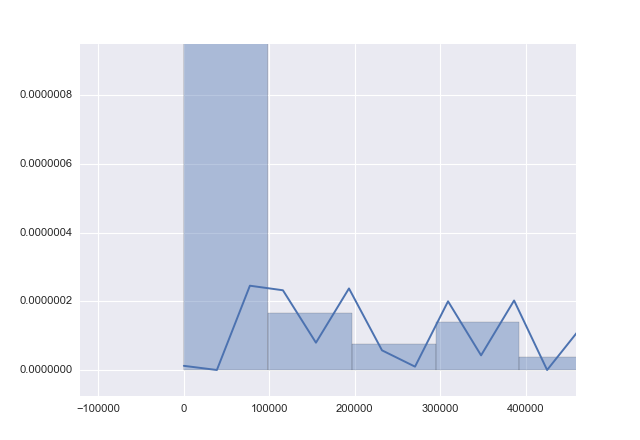

In [35]:
sns.distplot(scores)

## Conclusion

We have imported the Agribalyse database. In the process of importing, we found and resolved several problems:

1. First, we had to fix the names and categories of biosphere flow names, to make them compatible with the names and categories used in ecoinvent version 3.
2. Next, we created a new database for the new biosphere flows that we couldn't match.
3. We linked production flows to the activities that produced them, using a strategy that didn't use the field `categories`, as this field is not given consistently in SimaPro exports.
4. We switched some outputs to inputs, to be consistent with how ecoinvent models disposal and recycling processes.
5. We linked inputs to activities in ecoinvent 2.2, again ignoring the field `categories`, because SimaPro.
6. We created new processes to provide recycling services.
7. We deleted the unique identifying codes used by SimaPro, as they were not actually unique, and created our own codes.

This was a bit of a pain, but compared to other database exports, was actually not all that difficult. This is the sad truth of LCA data compatibility - it currently isn't all that great.